In [1]:
import os
#go back one directory
os.chdir("..")
# now go into source directory
os.chdir("source")


In [2]:
from tools.spaceX_ephem_tools import spacex_ephem_to_dataframe, parse_spacex_datetime_stamps, read_spacex_ephemeris, spacex_ephem_to_dataframe
from tools.utilities import yyyy_mm_dd_hh_mm_ss_to_jd, jd_to_utc

OpenJDK 64-Bit Server VM warning: Attempt to protect stack guard pages failed.
OpenJDK 64-Bit Server VM warning: Attempt to deallocate stack guard pages failed.


In [3]:
# read positions and velocities into orekit.measurement 

In [4]:
import pandas as pd
import numpy as np

In [5]:
def std_dev_from_lower_triangular(lower_triangular_data):
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())
    std_dev = np.sqrt(np.diag(cov_matrix))
    return std_dev

def spacex_ephem_to_df_w_cov(ephem_path: str) -> pd.DataFrame:
    """
    Convert SpaceX ephemeris data, including covariance terms, into a pandas DataFrame.

    Parameters
    ----------
    ephem_path : str
        Path to the ephemeris file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing parsed SpaceX ephemeris data, including covariance terms.
    """
    with open(ephem_path) as f:
        lines = f.readlines()

    # Remove header lines and select every 4th line starting from the first data line
    t_xyz_uvw = lines[4::4]

    # Extract t, x, y, z, u, v, w
    t = [float(i.split()[0]) for i in t_xyz_uvw]
    x = [float(i.split()[1]) for i in t_xyz_uvw]
    y = [float(i.split()[2]) for i in t_xyz_uvw]
    z = [float(i.split()[3]) for i in t_xyz_uvw]
    u = [float(i.split()[4]) for i in t_xyz_uvw]
    v = [float(i.split()[5]) for i in t_xyz_uvw]
    w = [float(i.split()[6]) for i in t_xyz_uvw]

    # Extract the 21 covariance terms (3 lines after each primary data line)
    covariance_data = {f'cov_{i+1}': [] for i in range(21)}
    for i in range(5, len(lines), 4):  # Start from the first covariance line
        cov_lines = lines[i:i+3]  # Get the three lines of covariance terms
        cov_values = ' '.join(cov_lines).split()
        for j, value in enumerate(cov_values):
            covariance_data[f'cov_{j+1}'].append(float(value))

    # Convert timestamps to strings and call parse_spacex_datetime_stamps
    t_str = [str(int(i)) for i in t]  # Convert timestamps to string
    parsed_timestamps = parse_spacex_datetime_stamps(t_str)

    # Calculate Julian Dates for each timestamp
    jd_stamps = np.zeros(len(parsed_timestamps))
    for i in range(len(parsed_timestamps)):
        jd_stamps[i] = yyyy_mm_dd_hh_mm_ss_to_jd(int(parsed_timestamps[i][0]), int(parsed_timestamps[i][1]), 
                                                 int(parsed_timestamps[i][2]), int(parsed_timestamps[i][3]), 
                                                 int(parsed_timestamps[i][4]), int(parsed_timestamps[i][5]), 
                                                 int(parsed_timestamps[i][6]))

    # Initialize lists for averaged position and velocity standard deviations
    sigma_positions = []
    sigma_velocities = []

    # Calculate averaged standard deviations for each row
    for _, row in pd.DataFrame(covariance_data).iterrows():
        std_devs = std_dev_from_lower_triangular(row.values)
        sigma_position = np.mean(std_devs[:3])  # Assuming I can average uncertainty in x, y, z
        sigma_velocity = np.mean(std_devs[3:])  # Assuming I can average uncertainty in u, v, w
        sigma_positions.append(sigma_position)
        sigma_velocities.append(sigma_velocity)

    # Construct the DataFrame with all data
    spacex_ephem_df = pd.DataFrame({
        't': t,
        'x': x,
        'y': y,
        'z': z,
        'u': u,
        'v': v,
        'w': w,
        'JD': jd_stamps,
        'sigma_pos': sigma_positions,
        'sigma_vel': sigma_velocities,
        **covariance_data
    })

    spacex_ephem_df['hours'] = (spacex_ephem_df['JD'] - spacex_ephem_df['JD'][0]) * 24 # hours since first timestamp
    # calculate UTC time by applying jd_to_utc() to each JD value
    spacex_ephem_df['UTC'] = spacex_ephem_df['JD'].apply(jd_to_utc)
    # TODO: I am gaining 3 milisecond per minute in the UTC time. Why?

    return spacex_ephem_df

In [6]:
spacex_ephem_dfwcov = spacex_ephem_to_df_w_cov("/Users/charlesc/Documents/GitHub/ERP_tools/external/ephems/starlink/MEME_57632_STARLINK-30309_3530645_Operational_1387262760_UNCLASSIFIED.txt")

In [17]:
(spacex_ephem_dfwcov['UTC'][4])

Timestamp('2023-12-19 06:49:41.999999')

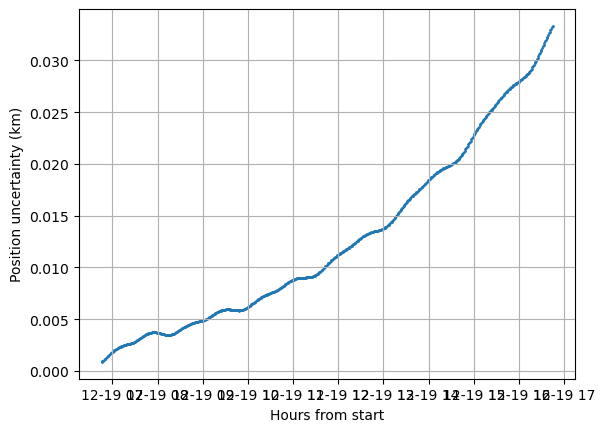

In [8]:
spacex_ephem_dfwcov.head()
import matplotlib.pyplot as plt

#calculate hours from start using spacex_ephem_dfwcov['JD']


plt.scatter(spacex_ephem_dfwcov['UTC'][0:600],spacex_ephem_dfwcov['sigma_pos'][0:600], s=1)
plt.xlabel('Hours from start')
plt.ylabel('Position uncertainty (km)')
plt.grid()
# plt.plot(spacex_ephem_dfwcov['JD'],spacex_ephem_dfwcov['sigma_vel'])

In [12]:
from orekit.pyhelpers import datetime_to_absolutedate
from org.orekit.estimation.measurements import PV, ObservableSatellite
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.time import AbsoluteDate
import pandas as pd
from datetime import datetime

sat_list = {    
    'STARLINK-30309': {
        'norad_id': 57632,  # For Space-Track TLE queries
        'cospar_id': '2023-122A',  # For laser ranging data queries
        'sic_id': '000',  # For writing in CPF files
        'mass': 800.0, # kg; v2 mini
        'cross_section': 100.0, # m2; TODO: get proper value
        'cd': 1.5, # TODO: compute proper value
        'cr': 1.0  # TODO: compute proper value
    }
}

sc_name = 'STARLINK-30309'  # Change the name to select a different satellite in the dict'  # Change the name to select a different satellite in the dict

laser_data_type = 'NPT'  

range_weight = 1.0 # Will be normalized later (i.e divided by the number of observations)
range_sigma = 1.0 # Estimated covariance of the range measurements, in meters

import numpy as np

from datetime import datetime

odDate = datetime(2029, 12, 19, 6, 45, 42, 14000)
collectionDuration = 2 # days
from datetime import timedelta
startCollectionDate = odDate + timedelta(days=-collectionDuration)

# Orbit propagator parameters
prop_min_step = 0.001 # s
prop_max_step = 300.0 # s
prop_position_error = 10.0 # m

# Estimator parameters
estimator_position_scale = 1.0 # m
estimator_convergence_thres = 1e-2
estimator_max_iterations = 25
estimator_max_evaluations = 35

from org.orekit.utils import Constants as orekit_constants
from org.orekit.frames import FramesFactory, ITRFVersion
from org.orekit.utils import IERSConventions
tod = FramesFactory.getTOD(IERSConventions.IERS_2010, False) # Taking tidal effects into account when interpolating EOP parameters
gcrf = FramesFactory.getGCRF()
itrf = FramesFactory.getITRF(IERSConventions.IERS_2010, False)
# Selecting frames to use for OD
eci = gcrf
ecef = itrf

from org.orekit.models.earth import ReferenceEllipsoid
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(ecef)
from org.orekit.bodies import CelestialBodyFactory
moon = CelestialBodyFactory.getMoon()
sun = CelestialBodyFactory.getSun()

from org.orekit.time import AbsoluteDate, TimeScalesFactory
utc = TimeScalesFactory.getUTC()
mjd_utc_epoch = AbsoluteDate(1858, 11, 17, 0, 0, 0.0, utc)

from org.orekit.propagation.analytical.tle import TLE
orekitTle = TLE(tleLine1, tleLine2)

from org.orekit.attitudes import NadirPointing
nadirPointing = NadirPointing(eci, wgs84Ellipsoid)

from org.orekit.propagation.analytical.tle import SGP4
sgp4Propagator = SGP4(orekitTle, nadirPointing, sat_list[sc_name]['mass'])

tleInitialState = sgp4Propagator.getInitialState()
tleEpoch = tleInitialState.getDate()
tleOrbit_TEME = tleInitialState.getOrbit()
tlePV_ECI = tleOrbit_TEME.getPVCoordinates(eci)

from org.orekit.orbits import CartesianOrbit
tleOrbit_ECI = CartesianOrbit(tlePV_ECI, eci, wgs84Ellipsoid.getGM())

from org.orekit.propagation.conversion import DormandPrince853IntegratorBuilder
integratorBuilder = DormandPrince853IntegratorBuilder(prop_min_step, prop_max_step, prop_position_error)

from org.orekit.propagation.conversion import NumericalPropagatorBuilder
from org.orekit.orbits import PositionAngleType
propagatorBuilder = NumericalPropagatorBuilder(tleOrbit_ECI,
                                               integratorBuilder, PositionAngleType.MEAN, estimator_position_scale)
propagatorBuilder.setMass(sat_list[sc_name]['mass'])
propagatorBuilder.setAttitudeProvider(nadirPointing)


# Earth gravity field with degree 64 and order 64
from org.orekit.forces.gravity.potential import GravityFieldFactory
gravityProvider = GravityFieldFactory.getNormalizedProvider(64, 64)
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
gravityAttractionModel = HolmesFeatherstoneAttractionModel(ecef, gravityProvider)
propagatorBuilder.addForceModel(gravityAttractionModel)

# Moon and Sun perturbations
from org.orekit.forces.gravity import ThirdBodyAttraction
moon_3dbodyattraction = ThirdBodyAttraction(moon)
propagatorBuilder.addForceModel(moon_3dbodyattraction)
sun_3dbodyattraction = ThirdBodyAttraction(sun)
propagatorBuilder.addForceModel(sun_3dbodyattraction)

# Solar radiation pressure
from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient, IsotropicRadiationClassicalConvention
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(float(sat_list[sc_name]['cross_section']), float(sat_list[sc_name]['cr']))
cross_section = float(sat_list[sc_name]['cross_section'])
cr = float(sat_list[sc_name]['cr'])

from org.orekit.forces.radiation import IsotropicRadiationSingleCoefficient
isotropicRadiationSingleCoeff = IsotropicRadiationSingleCoefficient(cross_section, cr)
from org.orekit.forces.radiation import SolarRadiationPressure
solarRadiationPressure = SolarRadiationPressure(sun, wgs84Ellipsoid,
                                                isotropicRadiationSingleCoeff)
propagatorBuilder.addForceModel(solarRadiationPressure)

# Relativity
from org.orekit.forces.gravity import Relativity
relativity = Relativity(orekit_constants.EIGEN5C_EARTH_MU)
propagatorBuilder.addForceModel(relativity)

# Atmospheric drag
from org.orekit.models.earth.atmosphere.data import MarshallSolarActivityFutureEstimation
msafe = MarshallSolarActivityFutureEstimation(
    MarshallSolarActivityFutureEstimation.DEFAULT_SUPPORTED_NAMES,
    MarshallSolarActivityFutureEstimation.StrengthLevel.AVERAGE)

from org.orekit.models.earth.atmosphere import NRLMSISE00
atmosphere = NRLMSISE00(msafe, sun, wgs84Ellipsoid)
#from org.orekit.forces.drag.atmosphere import DTM2000
#atmosphere = DTM2000(msafe, sun, wgs84Ellipsoid)
from org.orekit.forces.drag import IsotropicDrag
isotropicDrag = IsotropicDrag(sat_list[sc_name]['cross_section'], sat_list[sc_name]['cd'])
from org.orekit.forces.drag import DragForce
dragForce = DragForce(atmosphere, isotropicDrag)
propagatorBuilder.addForceModel(dragForce)


from org.hipparchus.linear import QRDecomposer
matrixDecomposer = QRDecomposer(1e-11)
from org.hipparchus.optim.nonlinear.vector.leastsquares import GaussNewtonOptimizer
optimizer = GaussNewtonOptimizer(matrixDecomposer, False)
from org.orekit.estimation.leastsquares import BatchLSEstimator
estimator = BatchLSEstimator(optimizer, propagatorBuilder)
estimator.setParametersConvergenceThreshold(estimator_convergence_thres)
estimator.setMaxIterations(estimator_max_iterations)
estimator.setMaxEvaluations(estimator_max_evaluations)


# Create an instance of ObservableSatellite (assuming single satellite with index 0)
observableSatellite = ObservableSatellite(0)
# Convert first 5 data points
for index, row in spacex_ephem_dfwcov.head(5).iterrows():
    # Create the AbsoluteDate for this row
    date = datetime_to_absolutedate((row['UTC']).to_pydatetime())

    # Convert position and velocity to Vector3D
    position = Vector3D(row['x'], row['y'], row['z'])
    velocity = Vector3D(row['u'], row['v'], row['w'])

    # Set standard deviations and base weight (these are placeholders)
    sigmaPosition = row['sigma_pos']
    sigmaVelocity = row['sigma_vel']
    baseWeight = 1.0     # Replace with actual value


    # Create PV instance
    orekitPV = PV(date, position, velocity, sigmaPosition, sigmaVelocity, baseWeight, observableSatellite)

    # Use orekitPV as required in your application


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.colors import SymLogNorm

# Create the output directory if it doesn't exist
output_dir = "output/covariance_heatmaps/starlink"
os.makedirs(output_dir, exist_ok=True)

# Function to create a symmetric correlation matrix from lower triangular covariance elements
def create_symmetric_corr_matrix(lower_triangular_data):
    # Create the symmetric covariance matrix
    cov_matrix = np.zeros((6, 6))
    row, col = np.tril_indices(6)
    cov_matrix[row, col] = lower_triangular_data
    cov_matrix = cov_matrix + cov_matrix.T - np.diag(cov_matrix.diagonal())

    # Convert to correlation matrix
    std_dev = np.sqrt(np.diag(cov_matrix))
    corr_matrix = np.divide(cov_matrix, std_dev[:, None])
    corr_matrix = np.divide(corr_matrix, std_dev[None, :])
    np.fill_diagonal(corr_matrix, 1)  # Fill diagonal with 1s for self-correlation
    return corr_matrix

# Axis labels
axis_labels = ['x', 'y', 'z', 'u', 'v', 'w']
# Assuming spacex_ephem_dfwcov is your DataFrame and it contains columns 'cov_1' to 'cov_21'
all_cov_data = spacex_ephem_dfwcov.loc[:, 'cov_1':'cov_21'].values

# Iterate through the first 1000 items
filenames = []
for i in range(min(1000, len(spacex_ephem_dfwcov))):
    # Create the symmetric correlation matrix
    corr_matrix = create_symmetric_corr_matrix(all_cov_data[i, :])

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(corr_matrix, annot=True, cmap='viridis', xticklabels=axis_labels, yticklabels=axis_labels, vmin=-1, vmax=1)
    plt.title(f'Starlink-57632 Correlation: {(spacex_ephem_dfwcov.loc[i, "t"])}')

    # Save the heatmap to a file
    filename = f'{output_dir}/spacex_corr_hm{i}.png'
    plt.savefig(filename, dpi=64)
    filenames.append(filename)
    plt.close()

import imageio

def create_animation(filenames, animation_path):
    images = [imageio.imread(filename) for filename in filenames]
    imageio.mimsave(animation_path, images, duration=0.1)

# Path for the output GIF
animation_path = "output/covariance_heatmaps/starlink/spacex_corr_heatmaps.gif"

# Create the animation
create_animation(filenames, animation_path)